<a href="https://colab.research.google.com/github/jecaJeca/english_for_cs_strasbourg_2021/blob/main/Practical_2_Controllable_GAN_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Layer
import keras.backend as kb

### Custum objects for Progressive GAN

In [ ]:


def _pixel_norm(x, epsilon=1e-8, channel_axis=-1):
  return x * tf.math.rsqrt(tf.reduce_mean(tf.square(x), axis=channel_axis, keepdims=True) + epsilon)
  
class PixelNorm(Layer):
  def __init__(self, channel_axis=-1, **kwargs):
    self.channel_axis = channel_axis
    super().__init__() 

  def call(self, x):
    return _pixel_norm(x, channel_axis=self.channel_axis)

  def compute_output_shape(self, input_shape):
    return input_shape
  
  def get_config(self):
    return {
        'channel_axis': self.channel_axis,
        **super().get_config()
    }
  

def _upscale2d(x, factor=2):
  # Channels last upscale
  assert isinstance(factor, int) and factor >= 1
  if factor == 1: return x
  
  s = x.shape
  x = tf.reshape(x, [-1, s[1], 1, s[2], 1, s[3]])
  x = tf.tile(x, [1, 1, 1, factor, factor, 1])
  x = tf.reshape(x, [-1, s[1] * factor, s[2] * factor, s[3]])
  return x

class Upscale2D(Layer):

  def call(self, x):
    return _upscale2d(x)

  def compute_output_shape(self, input_shape):
    batch_size, h, w, c = input_shape
    output_shape = [batch_size, h*2, w*2, c]
    return tuple(output_shape)
  

class ToChannelsLast(Layer):

  def call(self, x):
    return kb.permute_dimensions(x, [0, 2, 3, 1])

  def compute_output_shape(self, input_shape):
    batch_size, c, h, w = input_shape
    output_shape = [batch_size, h, w, c]
    return tuple(output_shape)
    
custom_objects = {
  'Upscale2D': Upscale2D,
  'PixelNorm': PixelNorm,
  'ToChannelsLast': ToChannelsLast,
}

### Load pretrained models

In [ ]:
!wget -q -O classifier.h5  "https://seafile.unistra.fr/f/2b5983982c8f4c15b457/?dl=1"
!wget -q -O keras_progan.hdf5 "https://seafile.unistra.fr/f/e46ba3de83624c96979e/?dl=1"

In [ ]:
cls = load_model('classifier.h5')
progan = load_model('keras_progan.hdf5', custom_objects=custom_objects)

### Test ProGAN model

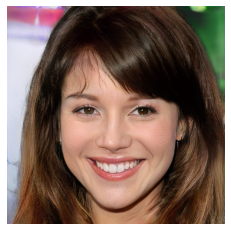

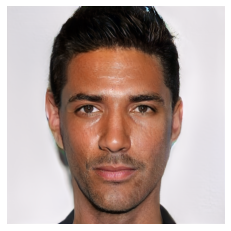

In [ ]:
latents = np.random.RandomState(1000).randn(1000, 512) # 1000 random latents
latents = latents[[477, 56]] # hand-picked top-10 from the authors, to verify replication.

imgs = progan.predict(latents)
# Predicts in range -1 to 1
imgs = (imgs + 1) / 2 # Now 0 to 1
imgs = np.clip(imgs, 0, 1)

plt.imshow(imgs[0])
plt.axis('off')
plt.savefig('test.jpg')
plt.figure()
plt.imshow(imgs[1])
plt.axis('off')
plt.savefig('test.jpg')

In [ ]:
progan.summary()

### Display function

In [ ]:
import matplotlib.pyplot as plt

def display_images(images, captions=None):
  num_ver = 1
  num_hor = 8
  plt.figure(figsize=(20,20))
  for i in range(len(images)):
    plt.subplot(num_ver,num_hor, i + 1)
    plt.imshow((images[i]*255).astype('uint8'))
    plt.axis('off')

  plt.tight_layout()

### Global variables

In [ ]:
# Globals variables : 
shape=[128,128]
feature_names   = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry',
                 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 
                 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
                 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [ ]:
#TODO:
weight = 0.01
n_images = 8
noise = tf.Variable(tf.random.normal(mean=0,stddev=0.1,shape=(n_images, 512)),trainable=True)
grad_step = 20
fake_image_history = []
target_indices = feature_names.index("Smiling") 
for i in range(grad_step):
  print(i)
  with tf.GradientTape() as tape:
    tape.watch(noise)
    fake_image = ((progan(noise)+1)/2)
    fake_image = tf.image.resize(fake_image,[shape[0],shape[1]])
    pred = tf.math.reduce_mean(cls(fake_image)[:, target_indices])
  
  grad = tape.gradient(pred,noise)
  noise.assign_add(grad*weight)
  #noise.assign_add(grad*(1/(i+1)))
  
  
  fake_image_history += [fake_image]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


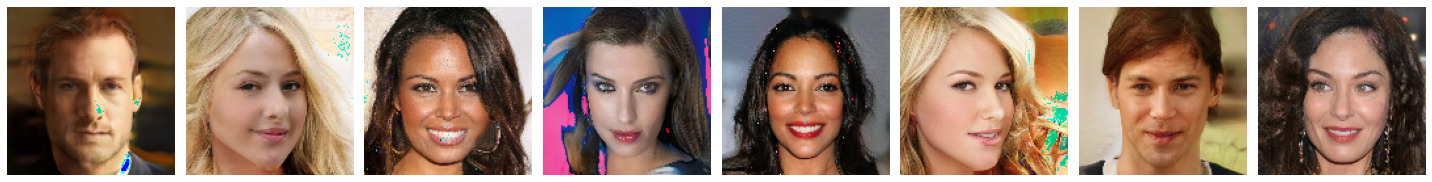

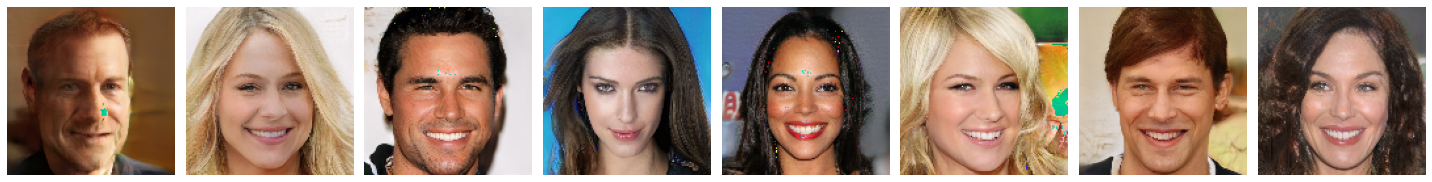

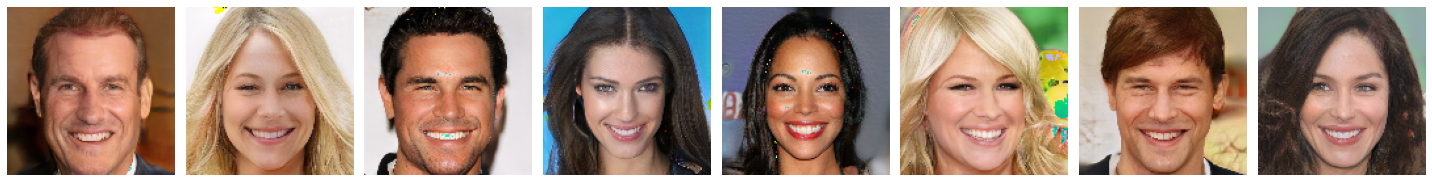

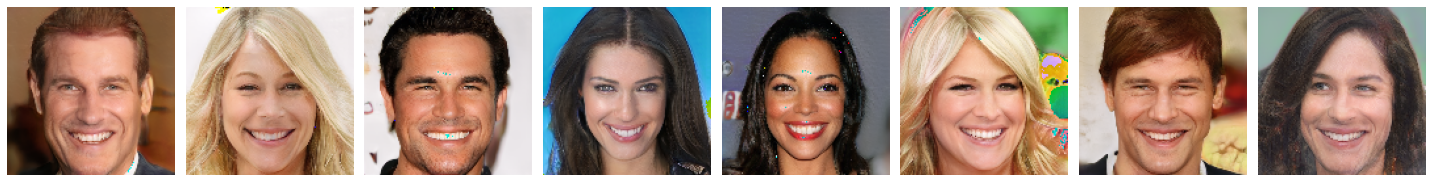

In [ ]:
for i in range(0,grad_step,5):
  display_images(fake_image_history[i].numpy())

### Playground



1.   Change feature (see feature_names)
2.   Change learning rate (weight variable)
3.   Change number of gradinet steps
3.   Observe entanglemnt in latent space

